# Generación de modelo MMPP

In [1]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from scipy import stats
import tqdm
import inspect
import warnings
from scipy.stats import johnsonsu   
import sqlalchemy as sa
import urllib
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

warnings.filterwarnings('ignore')

def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    
    ax.legend();
    
    return ax

def gen_muestra(parametros_dist, distribucio_param, num_muestras):
    
    muestras = distribucio_param.rvs(*parametros_dist, size=num_muestras)
    
    muestras =  [abs(ele) for ele in muestras]
        
    return sum(muestras)

In [2]:
#Variables 
pais='Colombia'

#rangos de fecha
#fin_historia = datetime.date.today()
fin_historia = datetime.date(2022,8,31)
#inicio_historia = fin_historia - datetime.timedelta(30 * 2) - MonthBegin(1)
inicio_historia= datetime.date(2022,1,1)

In [3]:
#Dataset de los consumos
df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio between ? and ?" , (inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d") ) )
df['year_month'] = df.FechaInicio.dt.to_period('M')
df['TipoMaterial'] = df['TipoMaterial'].str.strip()
df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()

#Dataset de los despachos
df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_serv = df_serv.fillna(value=np.nan)
df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
df_serv[['DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']] = df_serv['DescTecnica'].str.split("-", expand=True) 


In [9]:
#union con el dataframe de sepacho para obtener informacion de volumen y descripcion tecnica

df1 = pd.merge(df, df_serv[['Cluster', 'Entrega', 'VolPartida', 'TipoProducto', 'DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']], on='Entrega')
df1['cantidad_por_m3'] = df1['CantidadReal']/df1['VolPartida']
df1['cantidad_por_m3'] = df1['cantidad_por_m3'].astype(float)

#re categorizacion de materiales
df1['TipoMaterial2'] = np.select(
    [
        (df1['TextoBreveMaterial'].str.contains('CEMENTO,BLANCO')) | (df1['TextoBreveMaterial'].str.contains('CEM ART'))  | (df1['TextoBreveMaterial'].str.contains('CEM GRIS'))  | (df1['TextoBreveMaterial'].str.contains('Vertua')),
        (df1['TextoBreveMaterial'].str.contains('CENIZA')),
        (df1['TextoBreveMaterial'].str.contains('GRAVA')),
        (df1['TextoBreveMaterial'].str.contains('ARENA')),
        (df1['TipoMaterial'].str.contains('ADI')),
        (df1['TipoMaterial'].str.contains('ADC')),
        (df1['TipoMaterial'].str.contains('FIB'))
    ],
    [
        
        'CEMENTO',
        'CENIZA',
        'GRAVA',
        'ARENA',
        'ADITIVO',
        'OTROS',
        'FIBRA'
    ], default = df1['TextoBreveMaterial']
)

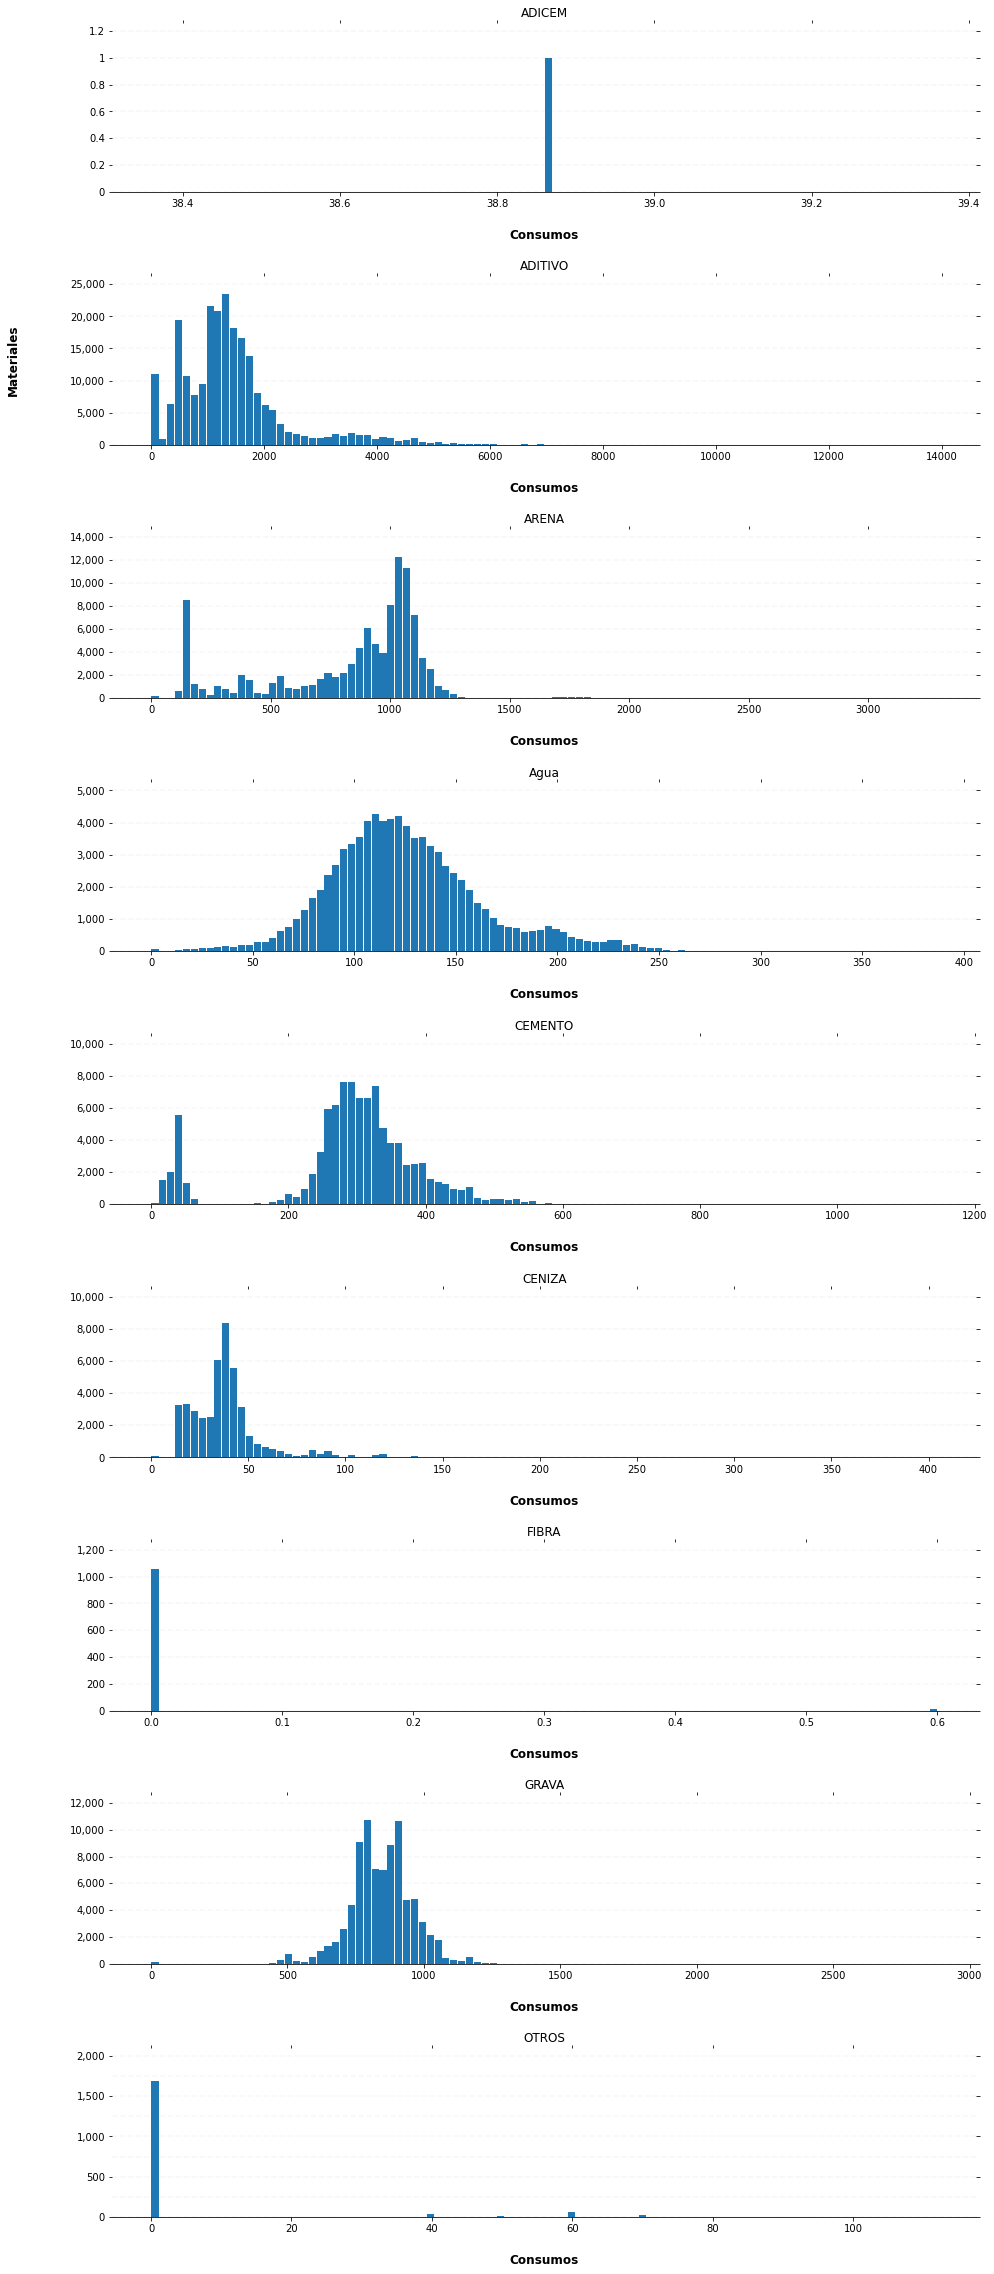

In [10]:
ax = df1.hist(column='cantidad_por_m3', label= df1['TipoProducto'], by='TipoMaterial2', bins=100, grid=False, figsize=(15,50), layout=(11,1), sharex=False, zorder=2, rwidth=0.9)

for i,x in enumerate(ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("Consumos", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("Materiales", labelpad=50, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    x.tick_params(axis='x', rotation=0)

In [11]:
df2 = pd.pivot_table(
    df1,
    index = ['Cluster','Entrega','TipoProducto'],
    columns =['TipoMaterial2'],
    values = ['cantidad_por_m3'],
    aggfunc = np.mean
).reset_index().set_axis(['Cluster','Entrega','TipoProducto', 'ADICEM', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'FIBRA', 'GRAVA', 'OTROS'], axis=1, inplace=False)

In [12]:
df2.head(50)

,Cluster,Entrega,TipoProducto,ADICEM,ADITIVO,ARENA,Agua,CEMENTO,CENIZA,FIBRA,GRAVA,OTROS
0,CLUSTER ANTIOQUIA,206170207,Convencional,NaN,692.009444,1081.000000,115.666667,261.166667,36.000000,NaN,948.333333,NaN
1,CLUSTER ANTIOQUIA,206170215,Convencional,NaN,690.980556,1080.000000,114.333333,261.166667,35.833333,NaN,948.666667,NaN
2,CLUSTER ANTIOQUIA,206170988,Tremie,NaN,1178.921128,1050.000000,115.538462,333.846154,59.230769,NaN,855.384615,NaN
3,CLUSTER ANTIOQUIA,206170999,Tremie,NaN,1178.921128,1050.000000,115.384615,333.846154,59.230769,NaN,856.153846,NaN
4,CLUSTER ANTIOQUIA,206171411,Tremie,NaN,1178.921128,1046.923077,119.692308,333.846154,59.230769,NaN,855.384615,NaN
5,CLUSTER ANTIOQUIA,206172458,Tremie,NaN,1178.392121,1044.545455,119.454545,333.636364,59.090909,NaN,853.636364,NaN
6,CLUSTER ANTIOQUIA,206172461,Convencional,NaN,1428.454714,980.714286,110.571429,328.571429,45.000000,NaN,949.285714,NaN
7,CLUSTER ANTIOQUIA,206173597,Convencional,NaN,1428.454714,980.000000,110.857143,328.571429,45.000000,NaN,949.285714,NaN
8,CLUSTER ANTIOQUIA,206173604,Convencional,NaN,1227.229167,996.666667,122.500000,285.833333,39.166667,NaN,944.166667,NaN
9,CLUSTER ANTIOQUIA,206173998,Convencional,NaN,732.448571,1093.571429,106.571429,245.428571,43.714286,NaN,902.428571,NaN


<AxesSubplot:>

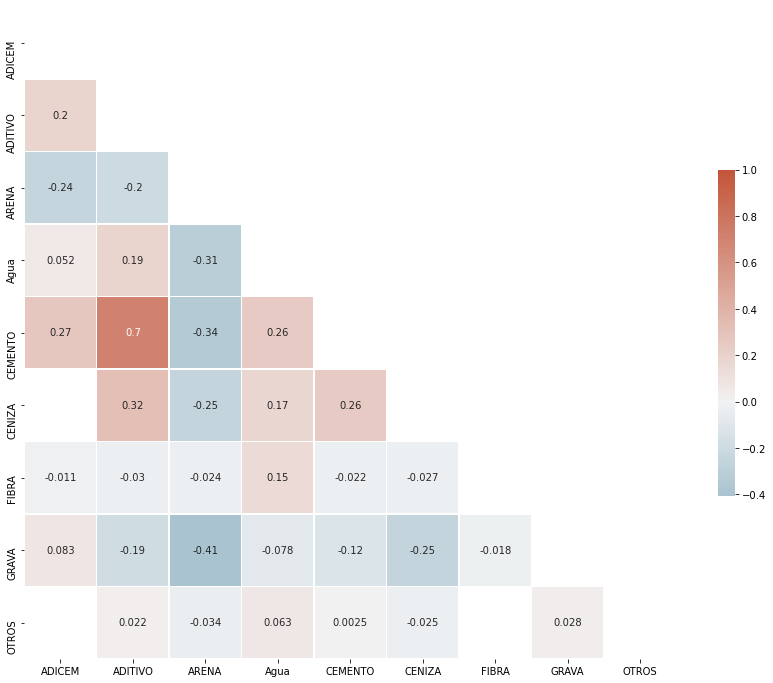

In [152]:
# Análisis de correlaciones
df_correlation = df2[['ADICEM', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'FIBRA', 'GRAVA', 'OTROS']].corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

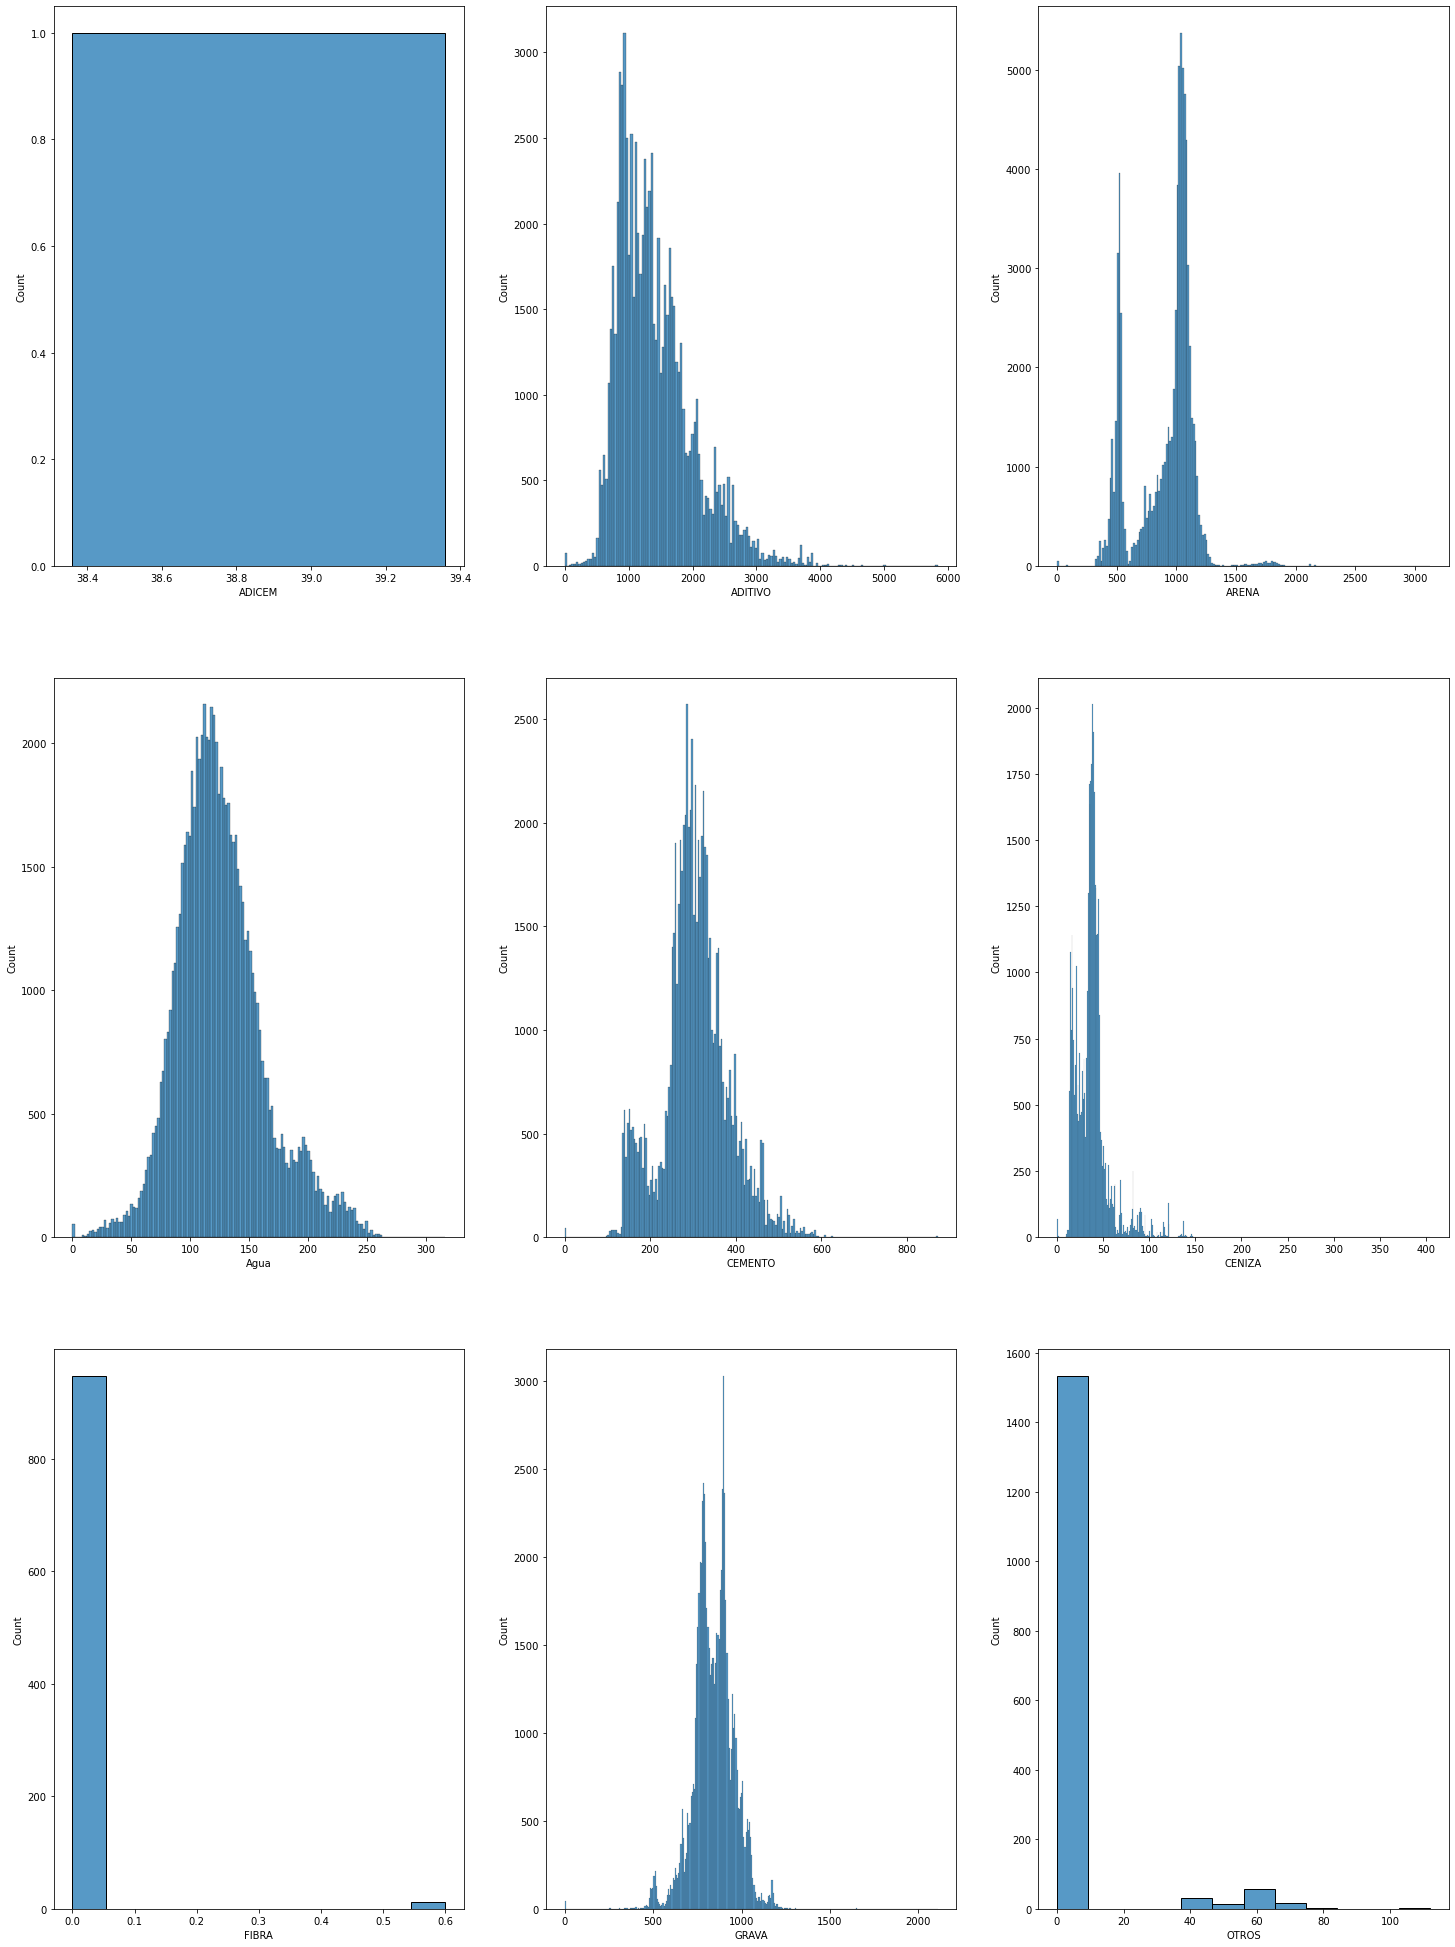

In [13]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 35))

for name, ax in zip(df2[['ADICEM', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'FIBRA', 'GRAVA', 'OTROS']].columns, axes.flatten()):
    sns.histplot(x = name, data = df2[['ADICEM', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'FIBRA', 'GRAVA', 'OTROS']], ax = ax)

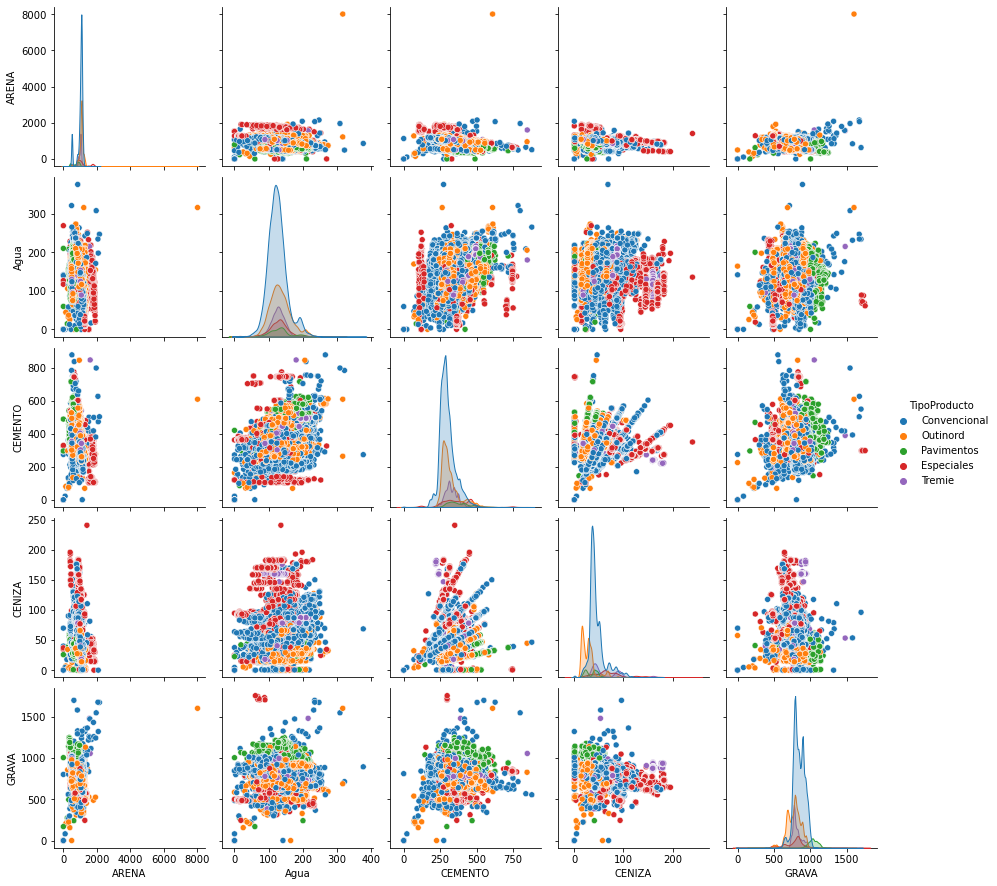

In [156]:
sns.pairplot(df2[['TipoProducto', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']], hue='TipoProducto')

## Distribución de probabilidad

## Agua

In [178]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[['Agua']]
datos = datos.loc[datos['Agua'].notnull()]

resultados = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-6.076324e+05,1.215273e+06,1.215312e+06,4,"{'a': -0.5989511417543866, 'b': 1.729812124762..."
1,genlogistic,-6.079566e+05,1.215919e+06,1.215948e+06,3,"{'c': 1.8137891617231316, 'loc': 110.865459446..."
2,exponnorm,-6.090303e+05,1.218067e+06,1.218096e+06,3,"{'K': 0.9322337750943963, 'loc': 107.344986388..."
3,hypsecant,-6.090828e+05,1.218170e+06,1.218189e+06,2,"{'loc': 125.2656807004864, 'scale': 18.6427134..."
4,dweibull,-6.092042e+05,1.218414e+06,1.218444e+06,3,"{'c': 1.1237469308885815, 'loc': 125.447821425..."
5,t,-6.093164e+05,1.218639e+06,1.218668e+06,3,"{'df': 5.117486435071015, 'loc': 125.088381376..."
6,dgamma,-6.093243e+05,1.218655e+06,1.218684e+06,3,"{'a': 1.1947656964561575, 'loc': 125.081946775..."
7,gennorm,-6.093345e+05,1.218675e+06,1.218704e+06,3,"{'beta': 1.3004360673707724, 'loc': 125.490033..."
8,logistic,-6.094178e+05,1.218840e+06,1.218859e+06,2,"{'loc': 125.69422120085446, 'scale': 15.757056..."
9,nct,-6.098504e+05,1.219709e+06,1.219748e+06,4,"{'df': 32.73637360921077, 'nc': 5.387724559026..."


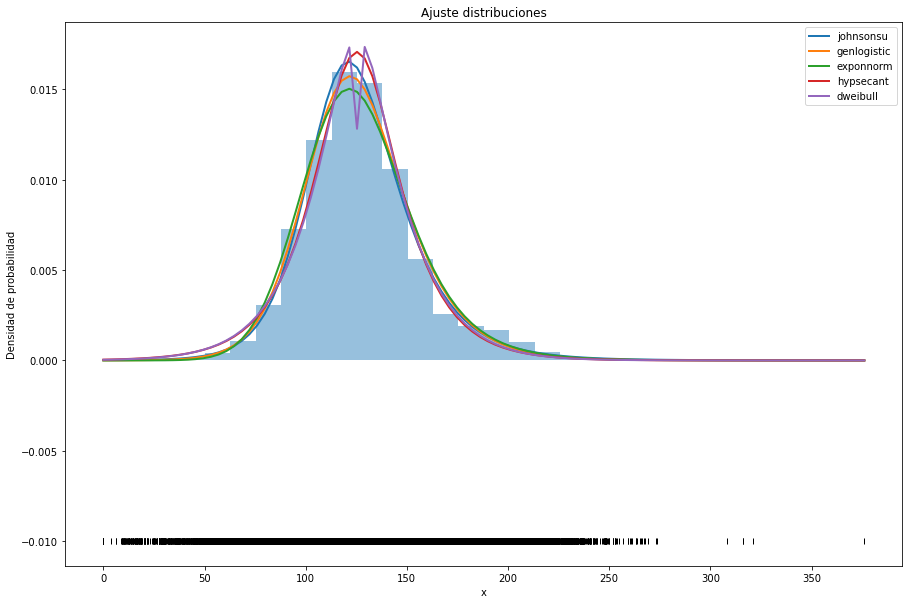

In [181]:
fig, ax = plt.subplots(figsize=(15,10))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:5],
    ax=ax
);

---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -0.5989511417543866, 'b': 1.729812124762451, 'loc': 110.53230395032347, 'scale': 39.90760852963754}
Log likelihood: -607632.4458940198
AIC:            1215272.8917880396
BIC:            1215311.92752251


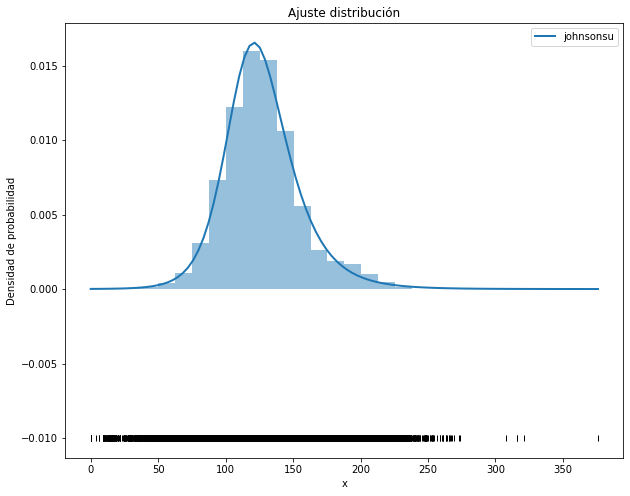

In [185]:
fig, ax = plt.subplots(figsize=(10,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
);

In [195]:
# Definición de la distribución
distribucion = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion.rvs(*parametros, size=5)

array([137.60120822, 131.70511992, 120.58719239, 132.56493574,
       133.17089619])

## Cemento

In [207]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[['CEMENTO']]
datos = datos.loc[datos['CEMENTO'].notnull()]

resultados_cemento = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_cemento

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-6.959613e+05,1.391931e+06,1.391970e+06,4,"{'a': -0.9856702756016726, 'b': 1.234217900008..."
1,exponnorm,-6.997425e+05,1.399491e+06,1.399520e+06,3,"{'K': 1.6696908216374022, 'loc': 256.686514608..."
2,genlogistic,-7.001043e+05,1.400215e+06,1.400244e+06,3,"{'c': 3.8615464035310385, 'loc': 233.820704281..."
3,skewnorm,-7.032912e+05,1.406588e+06,1.406618e+06,3,"{'a': 2.9068327150865416, 'loc': 242.281856524..."
4,nct,-7.033452e+05,1.406698e+06,1.406738e+06,4,"{'df': 22.498176900110018, 'nc': 8.48957739478..."
5,t,-7.049779e+05,1.409962e+06,1.409991e+06,3,"{'df': 3.1585996461742365, 'loc': 299.14819120..."
6,dgamma,-7.053147e+05,1.410635e+06,1.410665e+06,3,"{'a': 1.1258536806970199, 'loc': 299.351332619..."
7,dweibull,-7.055063e+05,1.411019e+06,1.411048e+06,3,"{'c': 1.0428333304469022, 'loc': 297.916206259..."
8,hypsecant,-7.055728e+05,1.411150e+06,1.411169e+06,2,"{'loc': 300.82443155534895, 'scale': 39.198558..."
9,gennorm,-7.056249e+05,1.411256e+06,1.411285e+06,3,"{'beta': 1.0160520471841215, 'loc': 296.470587..."


---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -0.9856702756016726, 'b': 1.2342179000082816, 'loc': 259.15761647265924, 'scale': 42.87716373922704}
Log likelihood: -695961.3399173026
AIC:            1391930.6798346052
BIC:            1391969.7156003523


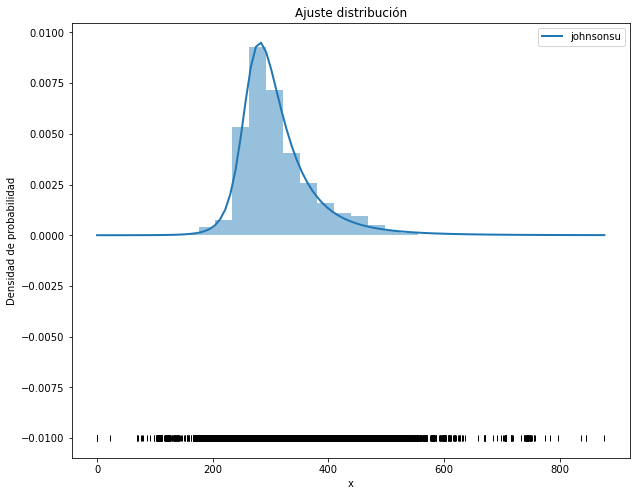

In [208]:
fig, ax = plt.subplots(figsize=(10,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados_cemento['distribucion'][0],
    ax=ax
);

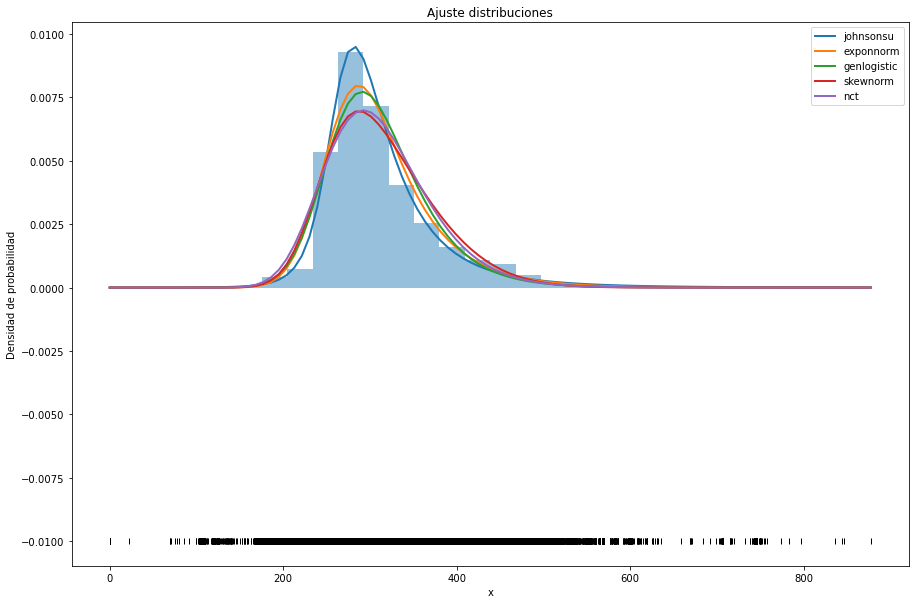

In [197]:
fig, ax = plt.subplots(figsize=(15,10))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][:5],
    ax=ax
);

In [46]:
# Definición de la distribución
distribucion = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion.rvs(*parametros, size=5)

array([240.91232511, 266.02161341, 351.92446811, 278.78796816,
       281.74744276])

In [47]:
parametros

(-0.791130469389487, 1.1469975669631287, 269.0444296034472, 39.281764027510114)

## Arena

In [199]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[['ARENA']]
datos = datos.loc[datos['ARENA'].notnull()]

resultados_arena = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_arena

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-8.108810e+05,1.621770e+06,1.621809e+06,4,"{'a': 0.5301531790180022, 'b': 0.7508697989868..."
1,tukeylambda,-8.184735e+05,1.636953e+06,1.636982e+06,3,"{'lam': -0.594336884047737, 'loc': 1048.599073..."
2,gennorm,-8.194392e+05,1.638884e+06,1.638914e+06,3,"{'beta': 0.6063877736410797, 'loc': 1053.00000..."
3,cauchy,-8.205518e+05,1.641108e+06,1.641127e+06,2,"{'loc': 1051.2642482594704, 'scale': 57.238438..."
4,dweibull,-8.210321e+05,1.642070e+06,1.642100e+06,3,"{'c': 0.8169421096362949, 'loc': 1052.49999999..."
5,dgamma,-8.223958e+05,1.644798e+06,1.644827e+06,3,"{'a': 0.7661805013364377, 'loc': 1051.99999999..."
6,laplace,-8.258943e+05,1.651793e+06,1.651812e+06,2,"{'loc': 1043.228287841191, 'scale': 117.331653..."
7,genlogistic,-8.263965e+05,1.652799e+06,1.652828e+06,3,"{'c': 0.3694138292408169, 'loc': 1109.66475454..."
8,hypsecant,-8.320381e+05,1.664080e+06,1.664100e+06,2,"{'loc': 1030.7710817569111, 'scale': 100.63221..."
9,logistic,-8.378664e+05,1.675737e+06,1.675756e+06,2,"{'loc': 1022.8204563495681, 'scale': 88.355760..."


---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': 0.5301531790180022, 'b': 0.750869798986831, 'loc': 1082.083143706537, 'scale': 50.47665204423206}
Log likelihood: -810880.9695592095
AIC:            1621769.939118419
BIC:            1621808.974633947


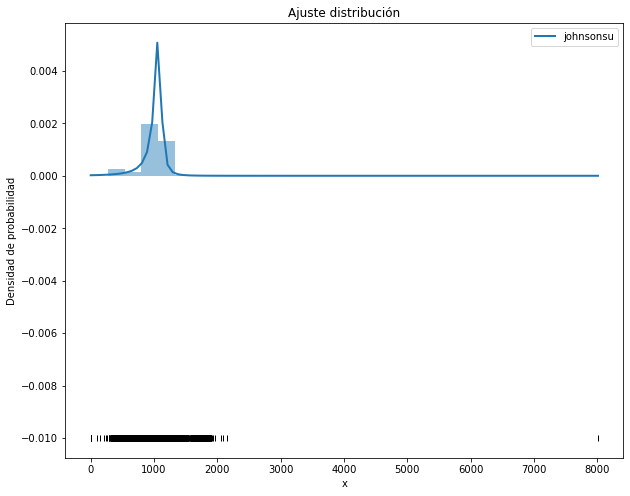

In [201]:
fig, ax = plt.subplots(figsize=(10,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados_arena['distribucion'][0],
    ax=ax
);

In [202]:
# Definición de la distribución
distribucion_arena = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion_arena.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion_arena.rvs(*parametros, size=5)

array([1105.28048912, 1042.38170825, 1019.85928661, 1050.81789535,
        717.13734084])

## Grava

In [17]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[df2['Cluster'] == 'CLUSTER CENTRO'][['GRAVA']]
datos = datos.loc[datos['GRAVA'].notnull()]

resultados_grava = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_grava

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-3.670395e+05,7.340869e+05,7.341233e+05,4,"{'a': 0.1278421155337059, 'b': 1.0813677638192..."
1,t,-3.673023e+05,7.346107e+05,7.346379e+05,3,"{'df': 2.6405806474361313, 'loc': 791.00405919..."
2,gennorm,-3.673060e+05,7.346180e+05,7.346452e+05,3,"{'beta': 0.8857126232177442, 'loc': 788.588235..."
3,dweibull,-3.673887e+05,7.347835e+05,7.348108e+05,3,"{'c': 0.9651796944203539, 'loc': 788.750000000..."
4,dgamma,-3.674529e+05,7.349118e+05,7.349391e+05,3,"{'a': 0.9762431935617479, 'loc': 788.666666666..."
5,laplace,-3.674782e+05,7.349603e+05,7.349785e+05,2,"{'loc': 788.8, 'scale': 48.57300636106036}"
6,hypsecant,-3.684593e+05,7.369226e+05,7.369407e+05,2,"{'loc': 790.2499142339971, 'scale': 41.7319989..."
7,genlogistic,-3.690736e+05,7.381533e+05,7.381806e+05,3,"{'c': 0.6731145633099913, 'loc': 808.395678003..."
8,logistic,-3.697728e+05,7.395495e+05,7.395677e+05,2,"{'loc': 789.8264340447442, 'scale': 35.7558933..."
9,cauchy,-3.715592e+05,7.431224e+05,7.431406e+05,2,"{'loc': 789.975817865187, 'scale': 30.34876270..."


---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': 0.1278421155337059, 'b': 1.0813677638192631, 'loc': 796.5992657906583, 'scale': 49.13648548945188}
Log likelihood: -367039.4558698419
AIC:            734086.9117396838
BIC:            734123.2953752633


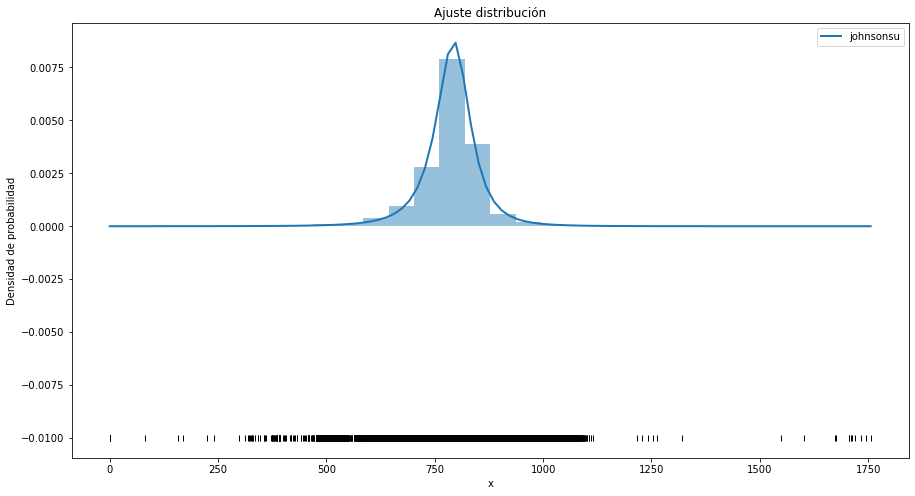

In [18]:
fig, ax = plt.subplots(figsize=(15,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados_grava['distribucion'][0],
    ax=ax
);

In [23]:
# Definición de la distribución
distribucion_grava = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion_grava.fit(datos.to_numpy())

# Muestreo aleatorio
muestras_grava = distribucion_grava.rvs(*parametros, size=627)

In [24]:
muestras_grava.sum()

491962.87060118216

## Ceniza

In [205]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[['CENIZA']]
datos = datos.loc[datos['CENIZA'].notnull()]

resultados_ceniza = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_ceniza

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-2.950692e+05,5.901464e+05,5.901829e+05,4,"{'a': -0.6191654767250839, 'b': 0.969402110608..."
1,exponnorm,-2.954682e+05,5.909425e+05,5.909698e+05,3,"{'K': 2.352265600503962, 'loc': 24.18418756970..."
2,nct,-2.956428e+05,5.912936e+05,5.913301e+05,4,"{'df': 4.746913921674343, 'nc': 3.392010941496..."
3,genextreme,-2.961923e+05,5.923905e+05,5.924179e+05,3,"{'c': -0.09488829073614885, 'loc': 34.13312821..."
4,moyal,-2.965919e+05,5.931877e+05,5.932059e+05,2,"{'loc': 31.818840939632416, 'scale': 10.702098..."
5,norminvgauss,-2.969147e+05,5.938374e+05,5.938739e+05,4,"{'a': 12.622964236345414, 'b': 11.792379146271..."
6,gumbel_r,-2.971223e+05,5.942486e+05,5.942668e+05,2,"{'loc': 34.977063299504096, 'scale': 16.548340..."
7,genlogistic,-2.971271e+05,5.942602e+05,5.942875e+05,3,"{'c': 549.9238368583656, 'loc': -69.3696336250..."
8,dweibull,-2.972505e+05,5.945070e+05,5.945343e+05,3,"{'c': 0.8507086061620562, 'loc': 38.4999999999..."
9,dgamma,-2.974452e+05,5.948964e+05,5.949238e+05,3,"{'a': 0.8063379326211786, 'loc': 38.4999999999..."


In [206]:
# Definición de la distribución
distribucion_ceniza = stats.johnsonsu

# Ajuste para obtener el valor de los parámetros
parametros   = distribucion_ceniza.fit(datos.to_numpy())

# Muestreo aleatorio
distribucion_ceniza.rvs(*parametros, size=5)

array([41.81170945, 49.12044578, 51.29134606, 34.62990326, 45.0644555 ])

## Aditivo

In [14]:
# Ajuste y comparación de distribuciones
# ==============================================================================
datos = df2[['ADITIVO']]
datos = datos.loc[datos['ADITIVO'].notnull()]

resultados_aditivo = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados_aditivo

1/28 Ajustando distribución: cauchy
2/28 Ajustando distribución: crystalball
3/28 Ajustando distribución: dgamma
4/28 Ajustando distribución: dweibull
5/28 Ajustando distribución: exponnorm
6/28 Ajustando distribución: genextreme
7/28 Ajustando distribución: genlogistic
8/28 Ajustando distribución: gennorm
9/28 Ajustando distribución: gumbel_l
10/28 Ajustando distribución: gumbel_r
11/28 Ajustando distribución: hypsecant
12/28 Ajustando distribución: johnsonsu
13/28 Ajustando distribución: kappa4
14/28 Ajustando distribución: laplace
15/28 Ajustando distribución: loggamma
16/28 Ajustando distribución: logistic
17/28 Ajustando distribución: loguniform
18/28 Ajustando distribución: moyal
19/28 Ajustando distribución: nct
20/28 Ajustando distribución: norm
21/28 Ajustando distribución: norminvgauss
22/28 Ajustando distribución: pearson3
23/28 Ajustando distribución: powernorm
24/28 Ajustando distribución: reciprocal
25/28 Ajustando distribución: skewnorm
26/28 Ajustando distribución: t
27

,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,johnsonsu,-6.056794e+05,1.211367e+06,1.211404e+06,4,"{'a': -2.4674049882021265, 'b': 1.824432346990..."
1,skewnorm,-6.058600e+05,1.211726e+06,1.211754e+06,3,"{'a': 5.56771892418244, 'loc': 700.20245421334..."
2,exponnorm,-6.058869e+05,1.211780e+06,1.211808e+06,3,"{'K': 2.7389107324727497, 'loc': 823.953150337..."
3,nct,-6.060220e+05,1.212052e+06,1.212089e+06,4,"{'df': 5.878610972163468, 'nc': 4.306201901726..."
4,gumbel_r,-6.062297e+05,1.212463e+06,1.212482e+06,2,"{'loc': 1151.6187524372963, 'scale': 445.35045..."
5,genlogistic,-6.062327e+05,1.212471e+06,1.212499e+06,3,"{'c': 310.91963111919154, 'loc': -1398.7370006..."
6,moyal,-6.064485e+05,1.212901e+06,1.212920e+06,2,"{'loc': 1063.6662638147718, 'scale': 288.72376..."
7,pearson3,-6.075615e+05,1.215129e+06,1.215157e+06,3,"{'skew': 0.7559464906079691, 'loc': 1414.60037..."
8,powernorm,-6.087398e+05,1.217486e+06,1.217513e+06,3,"{'c': 0.017095236646541126, 'loc': 450.0153164..."
9,norminvgauss,-6.099096e+05,1.219827e+06,1.219864e+06,4,"{'a': 33.972718741776504, 'b': 32.765159496336..."


---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -2.4674049882021265, 'b': 1.8244323469900663, 'loc': 484.0212429594061, 'scale': 445.4789549951974}
Log likelihood: -605679.4095326274
AIC:            1211366.8190652549
BIC:            1211403.9197683


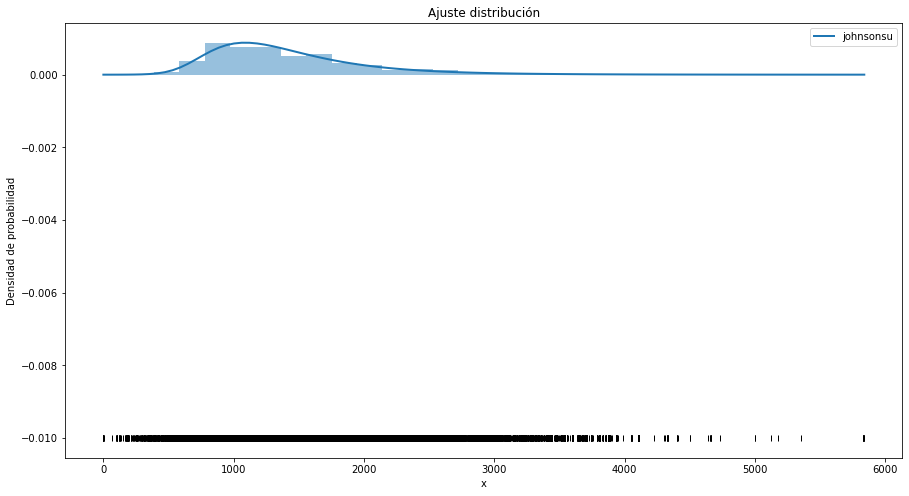

In [15]:
fig, ax = plt.subplots(figsize=(15,8))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados_aditivo['distribucion'][0],
    ax=ax
);

# Aplicacion del modelo

In [8]:
#Variables 
pais='Colombia'

#rangos de fecha
fin_historia = datetime.date(2022,8,31)
inicio_historia= datetime.date(2021,1,1)

lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']
version_forecast = 'PRECIERRE_FEB_2022'
pais = 'Colombia'

#Dataset de los consumos
df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio >= ?" , (inicio_historia.strftime("%Y-%m-%d")) )
df['year_month'] = df.FechaInicio.dt.to_period('M')
df['TipoMaterial'] = df['TipoMaterial'].str.strip()
df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()

#Dataset de los despachos
df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais, inicio_historia.strftime("%Y-%m-%d"), fin_historia.strftime("%Y-%m-%d")) )
df_serv = df_serv.fillna(value=np.nan)
df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
df_serv[['DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']] = df_serv['DescTecnica'].str.split("-", expand=True) 

#union con el dataframe de Despacho para obtener informacion de volumen y descripcion tecnica

df1 = pd.merge(df, df_serv[['Cluster', 'Planta', 'Ciudad' ,'Entrega', 'VolPartida', 'TipoProducto', 'DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']], on='Entrega')
df1['cantidad_por_m3'] = df1['CantidadReal']/df1['VolPartida']
df1['cantidad_por_m3'] = df1['cantidad_por_m3'].astype(float)


#re categorizacion de materiales
df1['TipoMaterial2'] = np.select(
    [
        (df1['TextoBreveMaterial'].str.contains('CEMENTO,BLANCO')) | (df1['TextoBreveMaterial'].str.contains('CEM ART')) | (df1['TextoBreveMaterial'].str.contains('CEM GRIS')),
        (df1['TextoBreveMaterial'].str.contains('CENIZA')),
        (df1['TextoBreveMaterial'].str.contains('GRAVA')),
        (df1['TextoBreveMaterial'].str.contains('ARENA')),
        (df1['TipoMaterial'].str.contains('ADI')),
        (df1['TipoMaterial'].str.contains('ADC')),
        (df1['TipoMaterial'].str.contains('FIB')),
        (df1['TipoMaterial'].str.contains('AGU'))
    ],
    [
        
        'CEMENTO',
        'CENIZA',
        'GRAVA',
        'ARENA',
        'ADITIVO',
        'OTROS',
        'FIBRA',
        'Agua'
    ], default = 'OTROS'#df1['TextoBreveMaterial']
)

df2 = pd.pivot_table(
    df1,
    index = ['Cluster', 'Planta', 'Ciudad','Entrega','TipoProducto'],
    columns =['TipoMaterial2'],
    values = ['cantidad_por_m3'],
    aggfunc = np.mean
).reset_index().set_axis(['Cluster','Planta', 'Ciudad','Entrega','TipoProducto', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'FIBRA', 'GRAVA', 'OTROS'], axis=1, inplace=False)

#Dataset del forecast
df_forecast = querySQL( "SELECT * FROM SCAC_AV7_DesagregacionPronosticoCiudadPlantaDiaTabla WHERE Version = ? " ,(version_forecast) )

#agrego informacion geografica        
nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )

cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()

"""
PARAMETROS:
df -> Dataframe con la informacion de CONSU_TICKET
material
cluster

"""
def generar_forecast_materiales( iteraciones ):
    # Definición de la distribución
    distribucion = stats.johnsonsu
    df_materiales = pd.DataFrame()

    for j in range(0, iteraciones):
        print("iteracion: " + str(j))
        for i in cluster_planta.values:
            #print(i)

            df_forecast_detalle = df_forecast[df_forecast['PlantaUnica']==i[1]].groupby(['Version','PlantaUnica', 'FechaEntrega'])['M3Forecast'].sum().reset_index()
            df_forecast_detalle['Centro'] = i[3]
            if(len(df_forecast_detalle) > 0 ):
                #ciclo para generar muestras por cada material
                for j in range(0, len(lista_materiales)):
                    #datos = df2[df2['Planta'] == i[1]][[lista_materiales[j]]]
                    #datos = df2[df2['Cluster'] == i[0]][[lista_materiales[j]]]
                    datos = df2[df2['Ciudad'] == i[2]][[lista_materiales[j]]]
                    datos = datos.loc[datos[lista_materiales[j]].notnull()]

                    if (len(datos) > 0):
                        # Ajuste para obtener el valor de los parámetros
                        parametros = distribucion.fit(datos.to_numpy()) 
                        #generacion de muestras
                        df_forecast_detalle[lista_materiales[j]] = df_forecast_detalle.apply(lambda x: gen_muestra(parametros, distribucion, int(x['M3Forecast'])), axis=1)
                    
                    else : 
                        df_forecast_detalle[lista_materiales[j]] = 0
                        
                if len(df_materiales) == 0:
                    df_materiales = df_forecast_detalle
                else: 
                    df_materiales = pd.concat([df_materiales, df_forecast_detalle])

    df_materiales = df_materiales.groupby(['Version', 'PlantaUnica', 'FechaEntrega', 'Centro'])['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].mean().reset_index()
    return df_materiales



In [35]:
datos = df2[df2['Ciudad'] == 'Bogotá'][['CEMENTO']]
parametros = distribucion.fit(datos.to_numpy())


(-0.791130469389487, 1.1469975669631287, 269.0444296034472, 39.281764027510114)

In [38]:
[*parametros]

[-0.791130469389487, 1.1469975669631287, 269.0444296034472, 39.281764027510114]

In [36]:
parametros


tuple

In [34]:
iteraciones = 10
result = generar_forecast_materiales(iteraciones)
result['Iteraciones'] = str(iteraciones) + "_ciudad"

iteracion: 0
iteracion: 1
iteracion: 2
iteracion: 3
iteracion: 4
iteracion: 5
iteracion: 6
iteracion: 7
iteracion: 8
iteracion: 9


## Actualización de datos en SQL

In [36]:
params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
        
result.to_sql("SCAC_AT40_desagregacion_materiales", engine, index=False, if_exists="append", schema="dbo")

## Modelo para identificacion y almacenamiento de parametros de distribución

Con el fin de no estar ajustando los datos cada vez que se desea ejecutar una desagregacion, se hace una funcion que identifica y almacena los parametros para futuros usos

### Actualizacion de parametros y reemplazo en SQL

In [9]:
def generar_parametros_materiales(inicio_param, fin_param, pais_param):

    lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

    #Dataset de los consumos
    df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio between ? and ?" , (inicio_param.strftime("%Y-%m-%d"), fin_param.strftime("%Y-%m-%d") ) )
    df['year_month'] = df.FechaInicio.dt.to_period('M')
    df['TipoMaterial'] = df['TipoMaterial'].str.strip()
    df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()

    #agrego informacion geografica        
    nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
    cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()


    #Dataset de los despachos
    df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais_param, inicio_param.strftime("%Y-%m-%d"), fin_param.strftime("%Y-%m-%d")) )
    df_serv = df_serv.fillna(value=np.nan)
    df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
    #df_serv[['DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']] = df_serv['DescTecnica'].str.split("-", expand=True) 

    #union con el dataframe de Despacho para obtener informacion de volumen y descripcion tecnica
    df1 = pd.merge(df, df_serv[['Cluster', 'Planta', 'Ciudad' ,'Entrega', 'VolPartida', 'TipoProducto']], on='Entrega')
    df1 = df1[df1['VolPartida'] > 0.0]
    df1['cantidad_por_m3'] = np.where( df1['VolPartida'] > 0.0, df1['CantidadReal']/df1['VolPartida'], 0)
    df1['cantidad_por_m3'] = df1['cantidad_por_m3'].astype(float)

    df1 = df1[df1['cantidad_por_m3'] > 0]


    #re categorizacion de materiales
    df1['TipoMaterial2'] = np.select(
        [
            (df1['TextoBreveMaterial'].str.contains('CEMENTO,BLANCO')) | (df1['TextoBreveMaterial'].str.contains('CEM ART')) | (df1['TextoBreveMaterial'].str.contains('CEM GRIS')),
            (df1['TextoBreveMaterial'].str.contains('CENIZA')),
            (df1['TextoBreveMaterial'].str.contains('GRAVA')),
            (df1['TextoBreveMaterial'].str.contains('ARENA')),
            (df1['TipoMaterial'].str.contains('ADI')),
            (df1['TipoMaterial'].str.contains('ADC')),
            #(df1['TipoMaterial'].str.contains('FIB')),
            (df1['TipoMaterial'].str.contains('AGU'))
        ],
        [

            'CEMENTO',
            'CENIZA',
            'GRAVA',
            'ARENA',
            'ADITIVO',
            'OTROS',
            #'FIBRA',
            'Agua'
        ], default = 'OTROS'#df1['TextoBreveMaterial']
    )

    df2 = pd.pivot_table(
        df1,
        index = ['Cluster', 'Planta', 'Ciudad','Entrega','TipoProducto'],
        columns =['TipoMaterial2'],
        values = ['cantidad_por_m3'],
        aggfunc = np.sum
    ).reset_index().set_axis(['Cluster','Planta', 'Ciudad','Entrega','TipoProducto', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA', 'OTROS'], axis=1, inplace=False)

    # Definición de la distribución
    distribucion = stats.johnsonsu
    df_parametros = pd.DataFrame()

    for i in cluster_planta.values:

        for j in range(0, len(lista_materiales)):
            datos = df2[df2['Planta'] == i[1]][[lista_materiales[j]]]
            datos = datos.loc[datos[lista_materiales[j]].notnull()]

            if (len(datos) > 0):
                # Ajuste para obtener el valor de los parámetros
                parametros = distribucion.fit(datos.to_numpy()) 
                parametros = [*parametros]

            dict_param = {'ubicacion': i[1], 'material': lista_materiales[j] ,'param1':parametros[0], 'param2':parametros[1], 'param3':parametros[2], 'param4':parametros[3] }

            if len(df_parametros) == 0:
                df_parametros = pd.DataFrame.from_dict([dict_param])
            else: 
                df_parametros = df_parametros.append([dict_param], ignore_index = True)

    try:
        params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
        engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        df_parametros.to_sql("SCAC_AT42_parametros_distribucion_materiales", engine, index=False, if_exists="replace", schema="dbo")
    except Exception as e:
        print(e)

In [181]:
#Variables 
pais='Colombia'

#rangos de fecha
inicio_historia= datetime.date(2022,4,1)
fin_historia = datetime.date(2022,8,31)

generar_parametros_materiales(inicio_historia, fin_historia, pais)

## Desagregación de materiales con base en el forecast

In [18]:
version_forecast = 'ESTADISTICO_ABR_2022'
pais = 'Colombia'
#Dataset del forecast
df_forecast = querySQL( "SELECT * FROM SCAC_AV7_DesagregacionPronosticoCiudadPlantaDiaTabla WHERE Version = ? and Pais = ? " ,(version_forecast, pais) )

#agrego informacion geografica        
nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()


In [19]:
#Dataset desagregacion materias primas
param_dist = querySQL( "SELECT * FROM SCAC_AT42_parametros_distribucion_materiales" , () )
iteraciones= 1

#def generar_forecast_materiales( iteraciones ):
# Definición de la distribución
distribucion = stats.johnsonsu
df_materiales = pd.DataFrame()
#materiales a desagregar
lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

for j in range(0, iteraciones):
    print("iteracion: " + str(j))
    for i in cluster_planta.values:
        #print(i)

        df_forecast_detalle = df_forecast[df_forecast['PlantaUnica']==i[1]].groupby(['Version','PlantaUnica', 'FechaEntrega'])['M3Forecast'].sum().reset_index()
        df_forecast_detalle['Centro'] = i[3]
        if(len(df_forecast_detalle) > 0 ):
            #ciclo para generar muestras por cada material
            for j in range(0, len(lista_materiales)):
                
                parametros_1 = param_dist[(param_dist['ubicacion']==i[1]) & (param_dist['material']==lista_materiales[j])][['param1','param2','param3','param4']].values
                
                if (len(parametros_1) > 0):
                    df_forecast_detalle[lista_materiales[j]] = df_forecast_detalle.apply(lambda x: gen_muestra(tuple([float(h) for h in parametros_1[0]]), distribucion, int(x['M3Forecast'])), axis=1)

                else : 
                    df_forecast_detalle[lista_materiales[j]] = 0

            if len(df_materiales) == 0:
                df_materiales = df_forecast_detalle
            else: 
                df_materiales = pd.concat([df_materiales, df_forecast_detalle])

df_materiales = df_materiales.groupby(['Version', 'PlantaUnica', 'FechaEntrega', 'Centro'])['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].mean().reset_index()
df_materiales['Iteraciones'] = str(iteraciones)
    #return df_materiales
#df_materiales

iteracion: 0


In [20]:
# GUARDAR EN EXCEL
writer = pd.ExcelWriter("./datos/MMPP_" + pais + "_" +  version_forecast + "_" +pd.to_datetime("now").strftime("%Y%m%d%H%M%S") + ".xlsx", engine='xlsxwriter')
df_materiales.to_excel( writer, sheet_name="Desagregacion", index=False )
writer.save()

In [65]:

##################################################params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
##################################################engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
        
#df_materiales.to_sql("SCAC_AT40_desagregacion_materiales", engine, index=False, if_exists="append", schema="dbo")


## Desagregación de materiales con base en la programación

In [41]:
def materias_primas_programacion( fecha_param, pais_param):
    
    #Dataset del forecast
    df_programacion = querySQL( "SELECT * FROM SCAC_AT15_Programacion7Dias WHERE FechaEntrega = ?" ,(fecha_param.strftime("%Y-%m-%d")))
    df_programacion['Posicion'] = df_programacion['Posicion'].astype(float)
    df_programacion['VolPartida'] = df_programacion['VolPartida'].astype(float)

    #agrego informacion geografica        
    nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais_param) )
    
    #materiales a desagregar
    lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

    estatus = ['Confirmada - Cabecera', 
               'Confirmada - Cabecera', 
               'En proceso - Cabecera',
               'Por confirmar - Cabecera',
               'Bloqueada - Cabecera']
    """
    df_programacion_dia = pd.merge(df_programacion, nombre_cluster[['Centro', 'PlantaUnica', 'Cluster']], left_on='Planta', right_on='Centro' )
    df_programacion_dia = df_programacion_dia[ (df_programacion_dia['Posicion'] < 3000) & 
                                             (df_programacion_dia['EstatusPedido'].isin(estatus) ) ][['Cluster','PlantaUnica', 'VolPartida', 'EstatusPedido']]\
                                             .groupby(['Cluster', 'PlantaUnica', 'EstatusPedido'])['VolPartida'].sum().reset_index()

    """
  
    #Dataset desagregacion materias primas
    param_dist = querySQL( "SELECT * FROM SCAC_AT42_parametros_distribucion_materiales" , () )
    iteraciones= 1


    # Definición de la distribución
    distribucion = stats.johnsonsu
    df_materiales = pd.DataFrame()

    for j in range(0, iteraciones):
       # print("iteracion: " + str(j))

        df_programacion_dia = pd.merge(df_programacion, nombre_cluster[['Centro', 'PlantaUnica', 'Cluster']], left_on='Planta', right_on='Centro' )
        df_programacion_dia = df_programacion_dia[ (df_programacion_dia['Posicion'] < 3000) & 
                                                 (df_programacion_dia['EstatusPedido'].isin(estatus) ) ][['Cluster','PlantaUnica', 'EstatusPedido', 'VolPartida']]\
                                                 .groupby(['Cluster', 'PlantaUnica', 'EstatusPedido'])['VolPartida'].sum().reset_index()

        lista_plantas = df_programacion_dia['PlantaUnica'].values
        for i in lista_plantas:
            #print(i)
            if(len(df_programacion_dia) > 0 ):
                #ciclo para generar muestras por cada material
                for j in range(0, len(lista_materiales)):
                    #print(lista_materiales[j])
                    param_dist[(param_dist['ubicacion']==i) & (param_dist['material']==lista_materiales[j])]
                    parametros_1 = param_dist[(param_dist['ubicacion']==i) & (param_dist['material']==lista_materiales[j])][['param1','param2','param3','param4']].values
                    #print(parametros_1)

                    if (len(parametros_1) > 0):
                        df_programacion_dia[lista_materiales[j]] = df_programacion_dia.apply(lambda x: gen_muestra(tuple([float(h) for h in parametros_1[0]]), distribucion, int(x['VolPartida'])), axis=1)

                    else : 
                        df_programacion_dia[lista_materiales[j]] = 0

                if len(df_materiales) == 0:
                    df_materiales = df_programacion_dia
                else: 
                    df_materiales = pd.concat([df_materiales, df_programacion_dia])

    df_materiales = df_materiales.groupby(['Cluster', 'PlantaUnica', 'EstatusPedido', 'VolPartida'])['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].median().reset_index()
    return df_materiales


In [42]:
fecha = datetime.date(2022,5, 3)
pais = 'Colombia'

df_prog = materias_primas_programacion(fecha, pais)


In [43]:
df_prog

,Cluster,PlantaUnica,EstatusPedido,VolPartida,ADITIVO,ARENA,Agua,CEMENTO,CENIZA,GRAVA
0,CLUSTER ANTIOQUIA,CO-PLANTA BELLO,Confirmada - Cabecera,14.00,5.668966e+04,14911.194012,1724.004696,4787.532994,561.390600,12338.456140
1,CLUSTER ANTIOQUIA,CO-PLANTA BELLO,Por confirmar - Cabecera,102.00,4.349982e+05,107454.760746,12776.091264,35708.071112,4005.694777,93207.505914
2,CLUSTER ANTIOQUIA,CO-PLANTA MEDELLIN,Confirmada - Cabecera,83.50,3.532453e+05,88316.227647,10281.792985,28530.560380,3265.712842,74775.193138
3,CLUSTER ANTIOQUIA,CO-PLANTA MEDELLIN,Por confirmar - Cabecera,105.50,4.502105e+05,111630.419095,13421.180239,36037.781132,4171.829773,96527.432594
4,CLUSTER ANTIOQUIA,CO-PLANTA RIONEGRO,Confirmada - Cabecera,231.00,1.006081e+06,246152.498545,29544.819843,79345.363768,8998.416805,210158.590409
5,CLUSTER ANTIOQUIA,CO-PLANTA RIONEGRO,Por confirmar - Cabecera,33.00,1.367379e+05,34655.660976,4209.780727,11206.900576,1295.187895,29554.699000
6,CLUSTER CENTRO,CO-PLANTA 240,Confirmada - Cabecera,171.00,7.692649e+05,181661.572828,21619.221160,58996.401693,6732.475078,156346.590306
7,CLUSTER CENTRO,CO-PLANTA 240,Por confirmar - Cabecera,55.00,2.361417e+05,58282.696314,7023.066015,19203.081048,2153.115882,49831.105877
8,CLUSTER CENTRO,CO-PLANTA BOSA,Confirmada - Cabecera,164.00,6.916172e+05,173467.123991,20836.758135,56859.738232,6459.194338,149374.637117
9,CLUSTER CENTRO,CO-PLANTA BOSA,Por confirmar - Cabecera,208.00,9.042381e+05,222605.604678,26113.238055,70471.803173,8270.694073,188624.488456


In [28]:
# GUARDAR EN EXCEL
writer = pd.ExcelWriter("./datos/MMPP_" + pais + "_" +fecha.strftime("%Y-%m-%d")  + "_" +pd.to_datetime("now").strftime("%Y%m%d%H%M%S") + ".xlsx", engine='xlsxwriter')
df_prog.to_excel( writer, sheet_name="Desagregacion", index=False )
writer.save()

## Metodo con valores puntuales

In [73]:
#plantas_param: lista con el nombre de las planta - segun scac_at1
#m3_especificos: lista numerica con los volumenes de concreto para los cuales se quiere generar una desagregacion de materiales
#iteraciones_param: cantidad de simulaciones a realizar
def materias_primas_especifico( plantas_param, m3_especificos, iteraciones_param):
    
    #Dataset con los parametros de la distribucion probabilistica hallados anteriormente
    param_dist = querySQL( "SELECT * FROM SCAC_AT42_parametros_distribucion_materiales" , () )

    #materiales a desagregar
    lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

    # Definición de la distribución - usualmente es johnsonsu la que mejor se ajusta
    distribucion = stats.johnsonsu
    # Dataframe vacion para almacenar la respuesta
    df_materiales = pd.DataFrame()

    for j in range(0, iteraciones_param):
        
        #se genera un dataframe con los valores que se pasaron como parametro
        datos = {'PlantaUnica': plantas_param, 'M3':m3_especificos}
        df_forecast_detalle = pd.DataFrame(datos)
        for i in plantas_param:
            
            if(len(df_forecast_detalle) > 0 ):
                #ciclo para generar muestras por cada material
                for j in range(0, len(lista_materiales)):

                    parametros_1 = param_dist[(param_dist['ubicacion']== i ) & (param_dist['material']==lista_materiales[j])][['param1','param2','param3','param4']].values

                    if (len(parametros_1) > 0):
                        df_forecast_detalle[lista_materiales[j]] = df_forecast_detalle.apply(lambda x: gen_muestra(tuple([float(h) for h in parametros_1[0]]), distribucion, int(x['M3'])), axis=1)

                    else : 
                        df_forecast_detalle[lista_materiales[j]] = 0

                if len(df_materiales) == 0:
                    df_materiales = df_forecast_detalle
                else: 
                    df_materiales = pd.concat([df_materiales, df_forecast_detalle])

    df_materiales = df_materiales.groupby(['PlantaUnica', 'M3'])['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].median().reset_index()
    df_materiales['Iteraciones'] = str(iteraciones_param)
    
    df_materiales['ADITIVO'] = (df_materiales['ADITIVO']/1000.0).astype(int)
    
    return df_materiales


In [76]:
plantas_metodo = ['CO-PLANTA 240']
m3_metodo = [336]

result = materias_primas_especifico(plantas_metodo, m3_metodo, 1)

In [77]:
result

,PlantaUnica,M3,ADITIVO,ARENA,Agua,CEMENTO,CENIZA,GRAVA,Iteraciones
0,CO-PLANTA 240,336,1007,368019.233561,38707.001427,107435.107821,13544.170495,289044.679564,1


## Validacion Vs Real

In [34]:
def comparacion_modelo_real(pais_param, inicio_param, fin_param, iteraciones_param ):
    ###################################### Paso 1. Definicion de parametros ###################################################
    #Variables 
    #pais_param='Colombia'

    #rangos de fecha
    #inicio_param= datetime.date(2022,4,1)
    #fin_param = datetime.date(2022,4,30)

    lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

    ###################################### Paso 2. Consulta base de datos ###################################################

    #Dataset de los consumos
    df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio >= ?" , (inicio_param.strftime("%Y-%m-%d")) )
    df['year_month'] = df.FechaInicio.dt.to_period('M')
    df['TipoMaterial'] = df['TipoMaterial'].str.strip()
    df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()

    #agrego informacion geografica        
    nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais_param) )
    cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()

    #Dataset de los despachos
    df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais_param, inicio_param.strftime("%Y-%m-%d"), fin_param.strftime("%Y-%m-%d")) )
    df_serv = df_serv.fillna(value=np.nan)
    df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
    
    ############## ELIMINO LA PLANTA QUE ME ESTA GENERANDO MUCHO RUIDO #######################
    df_serv = df_serv[df_serv['Centro'] != 'FB87']

    #Dataset parametros para desagregacion materias primas
    param_dist = querySQL( "SELECT * FROM SCAC_AT42_parametros_distribucion_materiales" , () )

    ###################################### Paso 3. Preprocesamiento de datos ###################################################

    #union con el dataframe de Despacho para obtener informacion de volumen y descripcion tecnica
    df1 = pd.merge(df, df_serv[['Cluster', 'Planta', 'Ciudad' ,'Entrega', 'VolPartida', 'TipoProducto']], on='Entrega')

    #re categorizacion de materiales
    df1['TipoMaterial2'] = np.select(
        [
            (df1['TextoBreveMaterial'].str.contains('CEMENTO,BLANCO')) | (df1['TextoBreveMaterial'].str.contains('CEM ART')) | (df1['TextoBreveMaterial'].str.contains('CEM GRIS')),
            (df1['TextoBreveMaterial'].str.contains('CENIZA')),
            (df1['TextoBreveMaterial'].str.contains('GRAVA')),
            (df1['TextoBreveMaterial'].str.contains('ARENA')),
            (df1['TipoMaterial'].str.contains('ADI')),
            (df1['TipoMaterial'].str.contains('ADC')),
            #(df1['TipoMaterial'].str.contains('FIB')),
            (df1['TipoMaterial'].str.contains('AGU'))
        ],
        [

            'CEMENTO',
            'CENIZA',
            'GRAVA',
            'ARENA',
            'ADITIVO',
            'OTROS',
            #'FIBRA',
            'Agua'
        ], default = 'OTROS'
    )

    df_materiales_real = pd.pivot_table(
        df1,
        index = ['Cluster', 'Planta', 'Ciudad','FechaInicio'],
        columns =['TipoMaterial2'],
        values = ['CantidadReal'],
        aggfunc = np.sum
    ).reset_index().set_axis(['Cluster','Planta', 'Ciudad','FechaInicio', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA', 'OTROS'], axis=1, inplace=False)

    df_materiales_real = df_materiales_real.fillna(0)

    #ajuste de unidades
    df_materiales_real['ADITIVO'] = (df_materiales_real['ADITIVO']/1000.0).astype(int)
    df_materiales_real['ARENA'] = (df_materiales_real['ARENA'] / 1000.0).astype(int)
    df_materiales_real['CEMENTO'] = (df_materiales_real['CEMENTO'] / 1000.0).astype(int)
    df_materiales_real['CENIZA'] = (df_materiales_real['CENIZA'] / 1000.0).astype(int)
    df_materiales_real['GRAVA'] = (df_materiales_real['GRAVA'] / 1000.0).astype(int)
    df_materiales_real['Agua'] = (df_materiales_real['Agua']).astype(int)

    #agregar medidas a los nombres de columnas
    df_materiales_real.rename(columns = {'FechaInicio': 'FechaEntrega', 'ADITIVO':'aditivo_real_L', 'ARENA':'arena_real_TN', 'Agua' : 'Agua_real_L', 'CEMENTO':'cemento_real_TN', 'CENIZA': 'ceniza_real_TN', 'GRAVA':'grava_real_TN' }, inplace = True)

    ###################################### Paso 4. Ejecucion del modelo  ###################################################

    df_volumen_diario = df_serv.groupby(['FechaEntrega', 'Centro', 'Planta'])['VolPartida'].sum().reset_index()

    # Definición de la distribución
    distribucion = stats.johnsonsu
    df_materiales = pd.DataFrame()
    #materiales a desagregar
    lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']
    
    iteraciones = iteraciones_param
    
    for k in range(0, iteraciones):

        for i in cluster_planta.values:
            #print(i)

            df_volumen_diario_detalle = df_volumen_diario[df_volumen_diario['Planta']==i[1]].groupby(['Planta', 'FechaEntrega'])['VolPartida'].sum().reset_index()
            df_volumen_diario_detalle['Centro'] = i[3]
            if(len(df_volumen_diario_detalle) > 0 ):
                #ciclo para generar muestras por cada material
                for j in range(0, len(lista_materiales)):

                    parametros_1 = param_dist[(param_dist['ubicacion']==i[1]) & (param_dist['material']==lista_materiales[j])][['param1','param2','param3','param4']].values

                    if (len(parametros_1) > 0):
                        df_volumen_diario_detalle[lista_materiales[j]] = df_volumen_diario_detalle.apply(lambda x: gen_muestra(tuple([float(h) for h in parametros_1[0]]), distribucion, int(x['VolPartida'])), axis=1)

                    else : 
                        df_volumen_diario_detalle[lista_materiales[j]] = 0

                if len(df_materiales) == 0:
                    df_materiales = df_volumen_diario_detalle
                else: 
                    df_materiales = pd.concat([df_materiales, df_volumen_diario_detalle])

    df_materiales = df_materiales.groupby([ 'Planta', 'FechaEntrega', 'Centro'])['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].median().reset_index()

    df_materiales = df_materiales.fillna(0)

    #ajuste de unidades
    df_materiales['ADITIVO'] = (df_materiales['ADITIVO']/1000.0).astype(int)
    df_materiales['ARENA'] = (df_materiales['ARENA'] / 1000.0).astype(int)
    df_materiales['CEMENTO'] = (df_materiales['CEMENTO'] / 1000.0).astype(int)
    df_materiales['CENIZA'] = (df_materiales['CENIZA'] / 1000.0).astype(int)
    df_materiales['GRAVA'] = (df_materiales['GRAVA'] / 1000.0).astype(int)
    df_materiales['Agua'] = (df_materiales['Agua']).astype(int)


    #agregar medidas a los nombres de columnas
    df_materiales.rename(columns = {'ADITIVO':'aditivo_modelo_L', 'ARENA':'arena_modelo_TN', 'Agua' : 'Agua_modelo_L', 'CEMENTO':'cemento_modelo_TN', 'CENIZA': 'ceniza_modelo_TN', 'GRAVA':'grava_modelo_TN' }, inplace = True)

    ###################################### Paso 5. Union entre real y pronostico  ##################################################
    df_resultados_modelo = pd.merge(df_materiales_real, df_materiales, on=['Planta', 'FechaEntrega'], how='left')
    df_resultados_modelo = df_resultados_modelo.fillna(0)
    #return df_resultados_modelo
    ###################################### Paso 6. calculo de MSE  ##################################################
#"""
    mse_aditivo = mean_squared_error(df_resultados_modelo['aditivo_real_L'], df_resultados_modelo['aditivo_modelo_L'])
    mse_arena = mean_squared_error(df_resultados_modelo['arena_real_TN'], df_resultados_modelo['arena_modelo_TN'])
    mse_cemento = mean_squared_error(df_resultados_modelo['cemento_real_TN'], df_resultados_modelo['cemento_modelo_TN'])
    mse_grava = mean_squared_error(df_resultados_modelo['grava_real_TN'], df_resultados_modelo['grava_modelo_TN'])
    mse_agua = mean_squared_error(df_resultados_modelo['Agua_real_L'], df_resultados_modelo['Agua_modelo_L'])

    return [mse_aditivo, mse_arena, mse_cemento, mse_grava, mse_agua] 
##"""

In [3]:
pais_param = 'Colombia'
fin_historia = datetime.date(2022,4,30) # fecha maxima de consulta
inicio_historia=datetime.date(2022,4,1)
df_resultados_modelo = comparacion_modelo_real(pais_param, inicio_historia, fin_historia)
# GUARDAR EN EXCEL PARA DEPURACIONES    
writer = pd.ExcelWriter("datos/validacion_modelo" + pais_param +  ".xlsx", engine='xlsxwriter')
df_resultados_modelo.to_excel( writer, sheet_name="Desagregacion", index=False )
writer.save()


## Determinar el mejor nivel de historia para el modelo

In [12]:
#Variables 

meses_historia = [1,2,3,4,5,6]

pais='Colombia'
resultados = []

for i in meses_historia:
    #rangos de fecha
    fin_historia = datetime.date(2022,3,30) # fecha maxima de consulta
    inicio_historia= fin_historia - MonthBegin(i) # fecha maxima menos n meses de historia
    
    generar_parametros_materiales(inicio_historia, fin_historia, pais)
    print("fin parametros: " + str(i))
    temp = comparacion_modelo_real(pais, inicio_historia, fin_historia)
    resultados.append({'meses_historia' : i, 'mse': temp})
    print("fin resultados: " + str(i))


fin parametros: 1
fin resultados: 1
fin parametros: 2
fin resultados: 2
fin parametros: 3
fin resultados: 3
fin parametros: 4
fin resultados: 4
fin parametros: 5
fin resultados: 5
fin parametros: 6
fin resultados: 6


In [37]:
#Variables 

iteraciones = [1,5,10,15,20]

pais='Colombia'
resultados = []

for i in iteraciones:
    #rangos de fecha
    fin_historia = datetime.date(2022,4,30) # fecha maxima de consulta
    inicio_historia= datetime.date(2022,4,1) # fecha maxima menos n meses de historia
    
    #generar_parametros_materiales(inicio_historia, fin_historia, pais)
    #print("fin parametros: " + str(i))
    temp = comparacion_modelo_real(pais, inicio_historia, fin_historia, i)
    resultados.append({'iteraciones' : i, 'mse': temp})
    print("fin resultados: " + str(i))

fin resultados: 1
fin resultados: 5
fin resultados: 10
fin resultados: 15
fin resultados: 20


In [38]:
resultados

[{'iteraciones': 1,
  'mse': [1418544.303776683,
   1197.0098522167489,
   198.23973727422003,
   14637.972085385878,
   33482883.344827585]},
 {'iteraciones': 5,
  'mse': [247455.37438423646,
   955.4220032840723,
   197.05747126436782,
   4586.128078817734,
   33582513.11494253]},
 {'iteraciones': 10,
  'mse': [101100.01477832512,
   993.5418719211823,
   198.57635467980296,
   1252.4220032840722,
   33473422.341543514]},
 {'iteraciones': 15,
  'mse': [97095.3776683087,
   882.5812807881773,
   197.74055829228243,
   1374.2118226600985,
   33554318.198686372]},
 {'iteraciones': 20,
  'mse': [96991.76026272577,
   885.3546798029556,
   197.76026272577997,
   1474.2282430213465,
   33572427.45648605]}]

### Aditivos

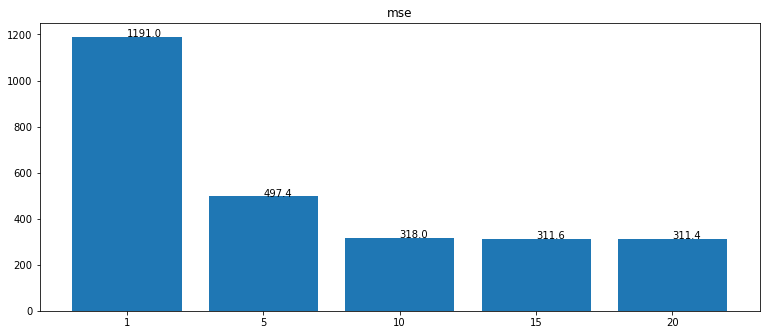

In [42]:
import matplotlib.pyplot as py

fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
#ejex = meses_historia
ejex = [str(h) for h in iteraciones]
ejey = [j['mse'][0] for j in resultados]
ejey = [round(j**0.5, 1) for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

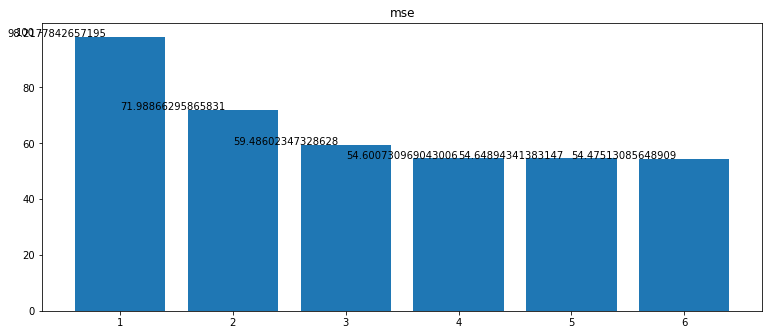

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
ejex = meses_historia
ejey = [j['mse'][1] for j in resultados]
ejey = [j**0.5 for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

## Arena

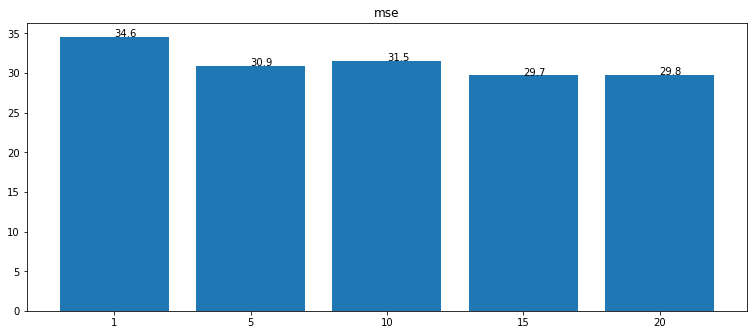

In [43]:
import matplotlib.pyplot as py

fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
ejex = [str(h) for h in iteraciones]
ejey = [j['mse'][1] for j in resultados]
ejey = [round(j**0.5, 1) for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

## Cemento

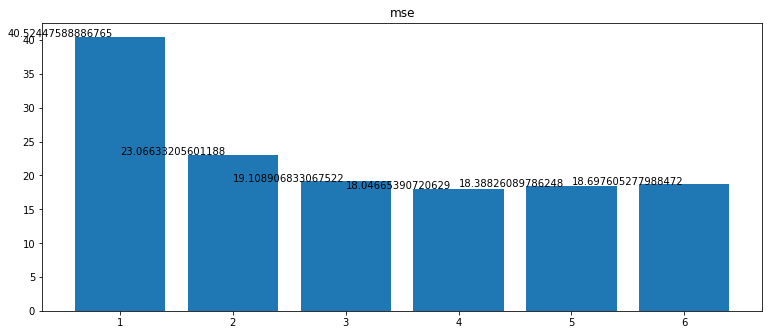

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
ejex = meses_historia
ejey = [j['mse'][2] for j in resultados]
ejey = [j**0.5 for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

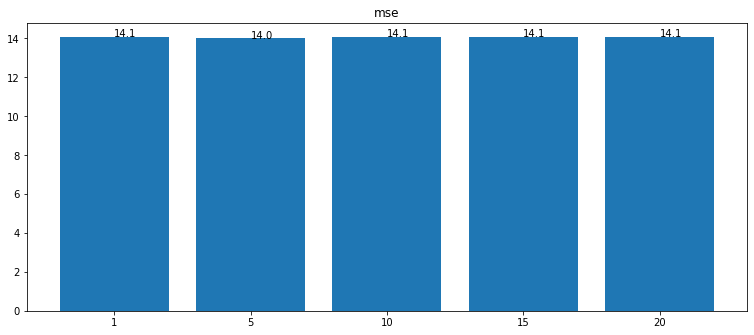

In [44]:

fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
#ejex = meses_historia
ejex = [str(h) for h in iteraciones]
ejey = [j['mse'][2] for j in resultados]
ejey = [round(j**0.5, 1) for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

## Grava

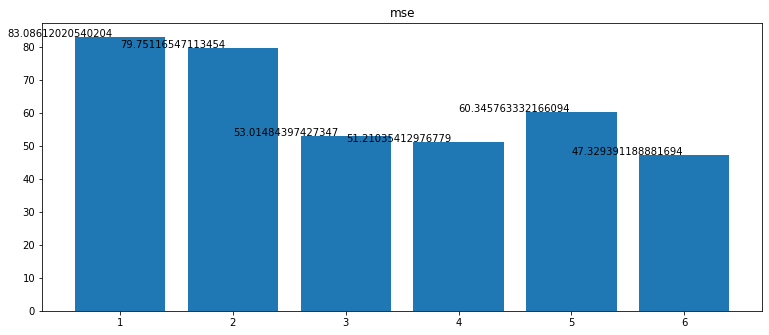

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
ejex = meses_historia
ejey = [j['mse'][3] for j in resultados]
ejey = [j**0.5 for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

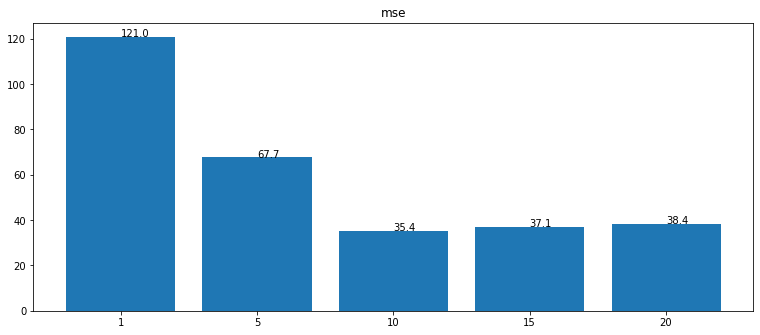

In [45]:
import matplotlib.pyplot as py

fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
#ejex = meses_historia
ejex = [str(h) for h in iteraciones]
ejey = [j['mse'][3] for j in resultados]
ejey = [round(j**0.5, 1) for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

## Agua

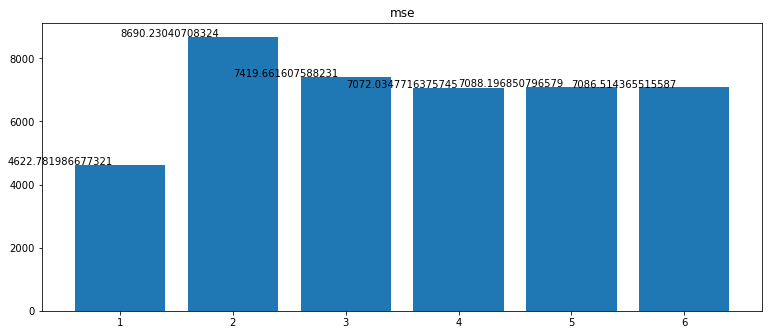

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
ejex = meses_historia
ejey = [j['mse'][4] for j in resultados]
ejey = [j**0.5 for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()

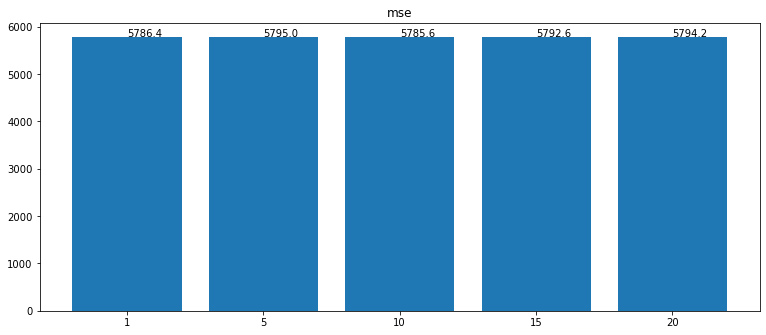

In [46]:
import matplotlib.pyplot as py

fig, ax = plt.subplots(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("mse")
#ejex = meses_historia
ejex = [str(h) for h in iteraciones]
ejey = [j['mse'][4] for j in resultados]
ejey = [round(j**0.5, 1) for j in ejey]
ax.bar(ejex, ejey)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejex,ejey,plt)
#plt.ylim(0.03, 0.0395)
plt.show()